# process

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
plt.style.use("seaborn")

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Index   5172 non-null   int64 
 1   Label   5172 non-null   bool  
 2   Text    5172 non-null   object
 3   Title1  5172 non-null   object
 4   Image   5172 non-null   object
 5   Title   5172 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 207.2+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Real and Fake News Instances')

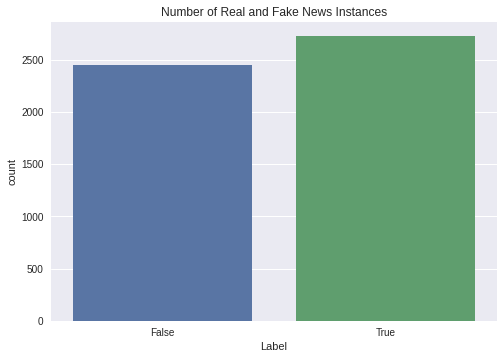

In [ ]:
#####################################################         Reading CSV        #################################################

from google.colab import drive
drive.mount('/content/drive')


PATH = os.getcwd()
DATADIR = PATH + '/drive/My Drive/Ds/All_data.csv'
df = pd.read_csv(DATADIR,delimiter=',',encoding='latin-1')

df.info()
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of Real and Fake News Instances')

In [ ]:
df.head()
df['Label'].value_counts()
#df['main_img_url'].value_counts()
df.head()

,Index,Label,Text,Title1,Image,Title
0,1,True,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",https://static01.nyt.com/images/2016/11/23/us/...,"They stood in line at Trump Tower, sometimes u..."
1,2,True,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,https://static01.nyt.com/images/2016/10/18/us/...,Donald J. Trump <U+2019>s foundation informed ...
2,3,True,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",https://static01.nyt.com/images/2016/11/12/us/...,President-elect Donald J. Trump won the White ...
3,4,True,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,https://static01.nyt.com/images/2016/10/21/bus...,An investment pitch for a new Texas hotel is t...
4,5,True,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,https://static01.nyt.com/images/2016/11/21/us/...,President-elect Donald J. Trump <U+2019>s wife...


In [ ]:
data = df[["Label","Text","Title","Image"]]
print(data['Label'].value_counts())
data.columns

True     2725
False    2447
Name: Label, dtype: int64


Index(['Label', 'Text', 'Title', 'Image'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5172 non-null   bool  
 1   Text    5172 non-null   object
 2   Title   5172 non-null   object
 3   Image   5172 non-null   object
dtypes: bool(1), object(3)
memory usage: 126.4+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


True     2725
False    2447
Name: Label, dtype: int64

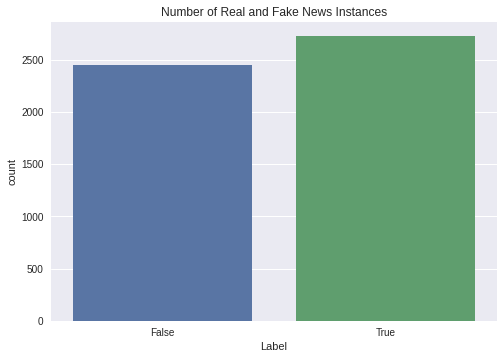

In [ ]:
data.info()
sns.countplot(data.Label)
plt.xlabel('Label')
plt.title('Number of Real and Fake News Instances')
data.Label.value_counts()

https://static01.nyt.com/images/2016/11/23/us/23spectacle1/23spectacle1-master768.jpg
0


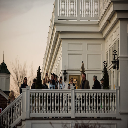

(128, 128, 3)
https://static01.nyt.com/images/2016/10/18/us/18fd-trumpfoundation/18fd-trumpfoundation-master675.jpg


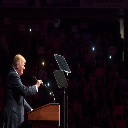

(128, 128, 3)
https://static01.nyt.com/images/2016/11/12/us/12tower1/12tower1-master768.jpg


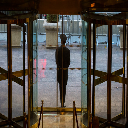

(128, 128, 3)
https://static01.nyt.com/images/2016/10/21/business/21VISA2sub/21VISA2sub-master768.jpg


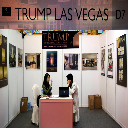

(128, 128, 3)
https://static01.nyt.com/images/2016/11/21/us/21melania/21melania-master768.jpg


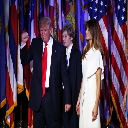

(128, 128, 3)


In [ ]:
CATEGORIES = ['True', 'False']
LENDIR=len(CATEGORIES)

IMG_SIZE = 128
#############################################################      Reading Image URL       ########################################################
from google.colab.patches import cv2_imshow
from skimage import io
import cv2
import urllib
import numpy as np
import imutils
from matplotlib import pyplot as plt

x=0
for i, j in data.iterrows(): 
  link=j["Image"]
  print(link)
  if(x%500==0):
    print(x)
  try:
    img_array = imutils.url_to_image(link)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    cv2_imshow(new_array)
    x=x+1
    print(new_array.shape)
  except Exception as e:  # in the interest in keeping the output clean... 
    #data.drop(data[ data['main_img_url'] == link ].index, inplace = True)
    print('2')
    pass
    #print(i,j)
  if(x==5): 
    break;   #.....show only one

IMG_SIZE = 128


In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)    # Randomly shuffling the dataframe rows
data.reset_index(drop = True, inplace = True) 

In [ ]:
#################################################################    Lables Encoding    #######################################################
labelencoder = LabelEncoder()
#for i,j in data.iterrows():
  #j['type'] = labelencoder.fit_transform(j['type'])
Y = data.Label
Y = labelencoder.fit_transform(Y)

In [ ]:
print(len(Y))
print(Y[:5])

5172
[1 1 1 1 0]


In [ ]:
##############################################################    Reading and Preprocessing Images       ###########################################################
from google.colab.patches import cv2_imshow
from skimage import io
import cv2
import urllib
import numpy as np
import imutils

training_data_img = []

IMG_SIZE = 128

def create_training_data():
 
  x=0
  for i, j in data.iterrows(): 
    
    link=j['Image']
    #print(link)
    if(x%500==0):
      print(x)

    try:
      #img_array=io.imread(link);
      img_array = imutils.url_to_image(link)
      
      new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

      x=x+1
      training_data_img.append([new_array,Y[i]])
      #print('1')
    except Exception as e:  # in the interest in keeping the output clean... 
      data.drop(data[ data['Image'] == link ].index, inplace = True)
      print('2')
      pass
      #print(i,j) 
 
create_training_data()
 
print(len(training_data_img))

0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
500
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1000
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1500
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2000
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2500
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3000
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3500
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4000
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4500
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4699


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1052 non-null   object
 1   Text    1052 non-null   object
 2   Title   1052 non-null   object
 3   Image   1052 non-null   object
dtypes: object(4)
memory usage: 41.1+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Other                   888
5G Corona Conspiracy    164
Name: Label, dtype: int64

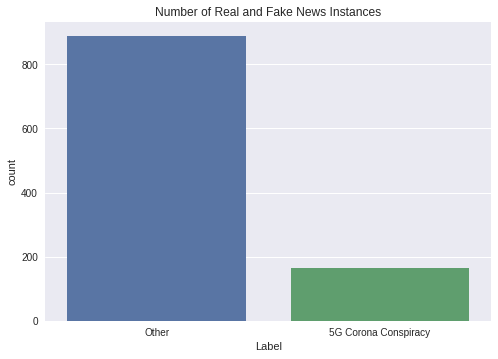

In [ ]:
data.info()
sns.countplot(data.Label)
plt.xlabel('Label')
plt.title('Number of Real and Fake News Instances')
data.Label.value_counts()

In [ ]:
print(type(training_data_img))
print(np.array(training_data_img).shape)
print(len(data))
#print(training_data_img[0])
print(len(training_data_img[0][0]))
print(len(training_data_img[0][0][0]))

<class 'list'>
(1052, 2)
1052
128
128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
from pickle import dump, load
# save the scaler
dump(training_data_img, open('training_data_img.pkl', 'wb'))

In [ ]:
# load the scaler
training_data_img = load(open('training_data_img.pkl', 'rb'))
 
print(len(training_data_img))
print(type(training_data_img))
 
print(np.array(training_data_img).shape)
 
print(len(training_data_img[0][0]))
print(len(training_data_img[0][0][0]))

1052
<class 'list'>
(1052, 2)
128
128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
X_img = []
labels = []
IMG_SIZE = 128

for features,label in training_data_img:
    X_img.append(features)
    labels.append(label)

X_img = np.array(X_img).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

X_img = X_img/255.0
print(type(X_img))
print((X_img).shape)
print(len(training_data_img))
#print(X_img[0])

############################################################################################      Image Preprocessing done     #########################################################################

<class 'numpy.ndarray'>
(1052, 128, 128, 3)
1052


In [ ]:
train_df = data.Text
print(train_df[0])
train_df = train_df.astype(str)
print(train_df[0])
print(len(data.Text))

Right... if this says "based on a true story" at the beginning, I will EAT a 5G tower. Is the next film going to be 5G Zombies Vs Corona Zombies? https://t.co/Q6Qz8GTDd3
Right... if this says "based on a true story" at the beginning, I will EAT a 5G tower. Is the next film going to be 5G Zombies Vs Corona Zombies? https://t.co/Q6Qz8GTDd3
1052


In [ ]:
#############################################################################################      Reading and preprocessing Text       ##################################################################################
# import warnings
# warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  
import pandas as pd                                 
import nltk       
import gensim                                  

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from gensim.models import Word2Vec                                   #For Word2Vec

X_text = data.Text

#X1,X2,Y1,Y2 = train_test_split(X_text,y_text,test_size=0.30)
X_text = X_text.astype(str)

########################################
## process texts in datasets
########################################
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

                
comments_text = process_comments(X_text, lower=True)

print(comments_text[0])

100%|██████████| 1052/1052 [00:00<00:00, 22124.43it/s]

Processing text dataset
['right', '...', 'if', 'this', 'says', '"', 'based', 'on', 'a', 'true', 'story', '"', 'at', 'the', 'beginning', ',', 'i', 'will', 'eat', 'a', '5g', 'tower', '.', 'is', 'the', 'next', 'film', 'going', 'to', 'be', '5g', 'zombies', 'vs', 'corona', 'zombies', '?', 'https', '://', 't', '.', 'co', '/', 'q6qz8gtdd3']


In [ ]:
################################################     1.  Remove stopwords         ######################################################
nltk.download("stopwords")
stop = set(stopwords.words('english')) 
print(stop)
print(len(X_text))
print(X_text.shape)
print(X_text.head())
print(type(X_text))

X_text_copy = X_text

import re               
temp =[]
snow = nltk.stem.SnowballStemmer('english')
for sentence in tqdm(X_text_copy):
    sentence = sentence.lower()                 # Converting to lowercase
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
    temp.append(words)
    
X_text_copy = temp    

print(X_text_copy[0])


  2%|▏         | 23/1052 [00:00<00:04, 218.77it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'herself', 'a', 'shan', 'how', "you'd", 'down', 'that', 'does', 'such', 'wouldn', 'no', 'of', 'yourself', 'yours', 'didn', 'these', 'is', 'then', 'where', 'mustn', 'up', "couldn't", 'being', 'as', "mustn't", 'theirs', 'hadn', "you're", 'her', 'hers', 'those', 'for', 'couldn', "needn't", 't', 'do', 'over', 'because', 'weren', 'during', 'this', 'were', 'again', 'them', 'both', 'have', "you'll", 'by', 'was', 's', "didn't", 'aren', 'be', 'not', 'before', 'mightn', 'out', 'very', "shouldn't", "that'll", 'i', 'been', 'all', "haven't", 'some', 'himself', 'don', "wouldn't", 'what', 'who', 'am', 'which', 'won', 'd', 'your', 'doesn', "hasn't", 'below', 'whom', 'has', 'ma', 'o', "you've", 'further', 'haven', 'ours', 'while', 'she', 'him', 'under', "hadn't", 'each', 'll', 'needn', 'at', 'than', 'yourselves', 'with', 'here', 'only', 'myself', 'other', 'on', 'if', 'when', 'now', 'until', "

100%|██████████| 1052/1052 [00:05<00:00, 203.36it/s]

['right', 'say', 'base', 'true', 'stori', 'begin', 'eat', '5g', 'tower', 'next', 'film', 'go', '5g', 'zombi', 'vs', 'corona', 'zombi', 'https:', 'co', 'q6qz8gtdd3']


In [ ]:
print(len(comments_text))
print(len(X_text_copy))
print(np.array(comments_text).shape)
print(np.array(X_text_copy).shape)
print(len(comments_text[0]))
print(len(X_text_copy[0]))

print("The vocabulary contains {} unique tokens".format(len(vocab)))

1052
1052
(1052,)
(1052,)
43
20
The vocabulary contains 9653 unique tokens


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
############################################     2.   Preparing Word vectors from Word2vec      #################################################
comments_backup = comments_text
comments_text = X_text_copy

import gensim
from gensim.models import Word2Vec
model_text = Word2Vec(comments_backup, size=100, window=5, min_count=5, workers=16, sg=0, negative=5)
word_vectors = model_text.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))         ##

#model_text.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])   #### Example

Number of word vectors: 1122


In [ ]:
print(comments_backup[0])

['right', '...', 'if', 'this', 'says', '"', 'based', 'on', 'a', 'true', 'story', '"', 'at', 'the', 'beginning', ',', 'i', 'will', 'eat', 'a', '5g', 'tower', '.', 'is', 'the', 'next', 'film', 'going', 'to', 'be', '5g', 'zombies', 'vs', 'corona', 'zombies', '?', 'https', '://', 't', '.', 'co', '/', 'q6qz8gtdd3']


In [ ]:
############################################      3.   Prepare sequence matrix from vocab         ###############################################
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}    ##
sequences_text = [[word_index.get(t, 0) for t in comment]
             for comment in comments_backup[:len(X_text)]]  ##

# pad
training_data_text = pad_sequences(sequences_text, maxlen=MAX_SEQUENCE_LENGTH,    
                     padding="pre", truncating="post")     ##
# list_classes = ["real", "fake"]
# y = train_df[list_classes].values
y = np.array(labels)
print('Shape of data tensor:', training_data_text.shape)
print('Shape of label tensor:', y.shape)

# test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
#                           truncating="post")
# print('Shape of test_data tensor:', test_data.shape)

#print(training_data_text[0])

Shape of data tensor: (1052, 200)
Shape of label tensor: (1052,)


In [ ]:
##########################################        4.   Prepare Text embedding vector for embedding layer in Bi-LSTM    #################################
WV_DIM = 100
nb_words_text = min(MAX_NB_WORDS, len(word_vectors.vocab))          ##
# we initialize the matrix with random numbers
wv_matrix_text = (np.random.rand(nb_words_text, WV_DIM) - 0.5) / 5.0     ##
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix_text[i] = embedding_vector
    except:
        pass      

In [ ]:
print(type(training_data_text))
training_data_text = np.array(training_data_text)
print(type(training_data_text))
print((training_data_text).shape)
print(len(training_data_text))
print(training_data_text[0])

######################################################################################       Text Preprocessing ends    #########################################################################################

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1052, 200)
1052
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 183  76  73  24 200
  45 613  20  16 316 444  45  48   2 780   9  32  57   0  16  13 341   1
  17   2 406   0 132  10  38  13   0 930  89   0  33   8   7   3   1   6
   5   0]


In [ ]:
##################################################################################      Reading and preprocessing Title      ##############################################################################
import numpy as np                                  
import pandas as pd                                 
import nltk       
import gensim                                  

X_title = data.Title

#X1,X2,Y1,Y2 = train_test_split(X_text,y_text,test_size=0.30)
X_title = X_title.astype(str)

comments_title = X_title
###################   1. Tokenisation  #########################
from keras.preprocessing.text import Tokenizer
max_words = 1000
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(comments_title)
sequences_2 = tok.texts_to_sequences(comments_title) ###### name training_data_title
training_data_title = sequence.pad_sequences(sequences_2,maxlen=max_len)


print(type(training_data_title))
training_data_title = np.array(training_data_title)
print(type(training_data_title))
print((training_data_title).shape)
print(len(training_data_title))
print(training_data_title[0])

###########################################################################################         Title Preprocessing Ends          ################################################################################

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1052, 300)
1052
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [ ]:
print(comments_title[0])

Right... if this says "based on a true story" at the beginning, I will EAT a 5G tower. Is the next film going to be 5G Zombies Vs Corona Zombies? https://t.co/Q6Qz8GTDd3


In [ ]:
#####################################################################################        Final Train and Test set             ##########################################################################

fin_X = []

total_data = len(training_data_text)
for i in range(len(data)):
  fin_X.append([X_img[i], training_data_text[i], training_data_title[i]])


print(len(fin_X))
print(np.array(fin_X).shape)
print(labels[0:5])
# print(fin_X[0])

1052
(1052, 3)
[1, 1, 1, 0, 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(type(fin_X))
print(np.array(fin_X[0]).shape)
print(len(fin_X))
print(fin_X[0][0])
print("Hello")
print(fin_X[0][1])
print("Hello")
print(fin_X[0][2])
# print("Hello")
# print(fin_X[0][1])
# print("Hello")
# print(fin_X[0][2])

<class 'list'>
(3,)
1052
[[[0.59215686 0.61176471 0.64313725]
  [0.63529412 0.64705882 0.67843137]
  [0.63137255 0.64705882 0.66666667]
  ...
  [0.08235294 0.05098039 0.05490196]
  [0.23529412 0.18039216 0.18823529]
  [0.26666667 0.21176471 0.21960784]]

 [[0.63529412 0.64313725 0.67843137]
  [0.64313725 0.66666667 0.69411765]
  [0.63529412 0.65098039 0.67058824]
  ...
  [0.09803922 0.05098039 0.05882353]
  [0.18431373 0.12156863 0.13333333]
  [0.23137255 0.16470588 0.17647059]]

 [[0.62745098 0.63529412 0.67058824]
  [0.63921569 0.66666667 0.69019608]
  [0.62745098 0.65098039 0.67058824]
  ...
  [0.1254902  0.0745098  0.08235294]
  [0.16862745 0.11372549 0.12156863]
  [0.20784314 0.15686275 0.16470588]]

 ...

 [[0.85882353 0.87058824 0.86666667]
  [0.90196078 0.90980392 0.78431373]
  [0.91764706 0.92941176 0.8       ]
  ...
  [0.91372549 0.94509804 0.78039216]
  [0.91764706 0.95294118 0.78039216]
  [0.89411765 0.90588235 0.79607843]]

 [[0.83921569 0.85490196 0.86666667]
  [0.9098039

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
###########################################################################################     Splitting final set to train and test     ###########################################################

from sklearn.model_selection import train_test_split
X_train_val,X_test,Y_train_val,Y_test = train_test_split(fin_X,labels,test_size=0.20)


In [ ]:

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X_train_val,Y_train_val,test_size=0.25)


In [ ]:
print("<-------X_train------>")
print(type(X_train))
print(np.array(X_train).shape)
print(np.array(X_train[0]).shape)
print(np.array(X_train[0][0]).shape)
print(np.array(X_train[0][1]).shape)
print(len(X_train))
print(type(X_train))
print(type(X_train[0]))
print(type(X_train[0][0]))
print(type(X_train[0][1]))
print("<-------Y_train------>")
print(type(Y_train))
print(type(Y_train[0]))
print((Y_train[0]))
print("<-------X_test------>")
print(type(X_test[0][0]))
print("<-------Y_test------>")
print(type(Y_test))
print(np.array(Y_train).shape)
print(len(Y_train))

print(type(X_train_val))
print(type(X_train))
print(type(X_val))
print(type(X_test))
print("\n")

print(len(X_train_val))
print(len(X_train))
print(len(X_val))
print(len(X_test))

<-------X_train------>
<class 'list'>
(630, 3)
(3,)
(128, 128, 3)
(200,)
630
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<-------Y_train------>
<class 'list'>
<class 'numpy.int64'>
1
<-------X_test------>
<class 'numpy.ndarray'>
<-------Y_test------>
<class 'list'>
(630,)
630
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


841
630
211
211


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
################################################################     Extracting image data from final train and test dataset     #######################################
X_train_img = []
X_test_img = []
X_val_img = []

for i in range(len(X_train)):
  temp1 = X_train[i][0].tolist()
  X_train_img.append(temp1)
  
for i in range(len(X_test)):
  temp1 = X_test[i][0].tolist()
  X_test_img.append(temp1)

for i in range(len(X_val)):
  temp1 = X_val[i][0].tolist()
  X_val_img.append(temp1)

In [ ]:
print("<-------X train------->")
print(type(X_train_img))
X_train_img = np.array(X_train_img)
print(type(X_train_img))
print(np.array(X_train_img).shape)
print(len(X_train_img))
print("<-------X test------->")
print(type(X_test_img))
X_test_img = np.array(X_test_img)
print(type(X_test_img))
print(np.array(X_test_img).shape)
print(len(X_test_img))
print("<-------X val------->")
print(type(X_val_img))
X_val_img = np.array(X_val_img)
print(type(X_val_img))
print(np.array(X_val_img).shape)
print(len(X_val_img))
print("<-------Y train------->")
print(type(Y_train))
Y_train = np.array(Y_train)
print(type(Y_train))
print(np.array(Y_train).shape)
print(len(Y_train))
print("<-------Y test------->")
print(type(Y_test))
Y_test = np.array(Y_test)
print(type(Y_test))
print(np.array(Y_test).shape)
print(len(Y_test))
print("<-------Y val------->")
print(type(Y_val))
Y_val = np.array(Y_val)
print(type(Y_val))
print(np.array(Y_val).shape)
print(len(Y_val))

<-------X train------->
<class 'list'>
<class 'numpy.ndarray'>
(630, 128, 128, 3)
630
<-------X test------->
<class 'list'>
<class 'numpy.ndarray'>
(211, 128, 128, 3)
211
<-------X val------->
<class 'list'>
<class 'numpy.ndarray'>
(211, 128, 128, 3)
211
<-------Y train------->
<class 'list'>
<class 'numpy.ndarray'>
(630,)
630
<-------Y test------->
<class 'list'>
<class 'numpy.ndarray'>
(211,)
211
<-------Y val------->
<class 'list'>
<class 'numpy.ndarray'>
(211,)
211


In [ ]:
#######################################################################   Extracting Title from final dataset  ###############################################################
X_train_title = []
X_val_title = []
X_test_title = []

for i in range(len(X_train)):
  temp1 = X_train[i][2].tolist()
  X_train_title.append(temp1)
  
for i in range(len(X_val)):
  temp1 = X_val[i][2].tolist()
  X_val_title.append(temp1)

for i in range(len(X_test)):
  temp1 = X_test[i][2].tolist()
  X_test_title.append(temp1)

In [ ]:
print("<-------X train------->")
print(type(X_train_title))
X_train_title = np.array(X_train_title)
print(type(X_train_title))
print(np.array(X_train_title).shape)
print(len(X_train_title))
print("<-------X test------->")
print(type(X_test_title))
X_test_title = np.array(X_test_title)
print(type(X_test_title))
print(np.array(X_test_title).shape)
print(len(X_test_title))
print("<-------X val------->")
print(type(X_val_title))
X_val_title = np.array(X_val_title)
print(type(X_val_title))
print(np.array(X_val_title).shape)
print(len(X_val_title))
print("\n")
print("<-------Y train------->")
print(type(Y_train))
Y_train = np.array(Y_train)
print(type(Y_train))
print(np.array(Y_train).shape)
print(len(Y_train))
print("<-------Y test------->")
print(type(Y_test))
Y_test = np.array(Y_test)
print(type(Y_test))
print(np.array(Y_test).shape)
print(len(Y_test))
print("<-------Y val------->")
print(type(Y_val))
Y_val = np.array(Y_val)
print(type(Y_val))
print(np.array(Y_val).shape)
print(len(Y_val))

<-------X train------->
<class 'list'>
<class 'numpy.ndarray'>
(630, 300)
630
<-------X test------->
<class 'list'>
<class 'numpy.ndarray'>
(211, 300)
211
<-------X val------->
<class 'list'>
<class 'numpy.ndarray'>
(211, 300)
211


<-------Y train------->
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(630,)
630
<-------Y test------->
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(211,)
211
<-------Y val------->
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(211,)
211


# Model

In [ ]:
############################################################################################    VGG16  Model   ###########################################################################
from keras.applications import vgg16
from keras.models import Model
import keras

input_shape = (IMG_SIZE, IMG_SIZE, 3)    

vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)


###############  Without fine tuning
vgg_model.trainable = False                
for layer in vgg_model.layers:
    layer.trainable = False


import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9740e15eb8>,input_15,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973ef27588>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97438487b8>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f973db49780>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973b90ff98>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973e513748>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f973f5f1198>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973f5fb128>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973f1f1a90>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f973f599da0>,block3_conv3,False


In [ ]:
#############    VGG Feature Extraction    #####################
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=1)
    return features
    
train_feat_vgg = get_bottleneck_features(vgg_model, X_train_img)
val_feat_vgg = get_bottleneck_features(vgg_model, X_val_img)
test_feat_vgg = get_bottleneck_features(vgg_model, X_test_img)

print('Train Bottleneck Features:', train_feat_vgg.shape, 
      '\nValidation Bottleneck Features:', val_feat_vgg.shape, 
      '\nTest Bottleneck Features:', test_feat_vgg.shape)

7/7 [==============================] - 34s 5s/step
Train Bottleneck Features: (630, 8192) 
Validation Bottleneck Features: (211, 8192) 
Test Bottleneck Features: (211, 8192)


In [ ]:
print(vgg_model.output_shape[1])

8192


In [ ]:
######################################################################################     Image classifier model architecture   ####################################################################
from tensorflow.python.keras import Sequential
from keras.applications import Xception
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPooling2D,  Flatten, InputLayer, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.utils import plot_model

# ###### Part 1 - Initialising the CNN ------>
classifier_img = Sequential()

# ##### VGG without aug --------->
input_layer = vgg_model.output_shape[1]
classifier_img.add(InputLayer(input_shape=(input_layer,)))

# # ######  VGG with Aug --------->
# # classifier_img.add(vgg_model)

# ###### Full Connection ->
classifier_img.add(Dense(units = 512, activation = 'relu',input_dim = input_layer))
classifier_img.add(BatchNormalization())
classifier_img.add(Dropout(0.5))
classifier_img.add(Flatten())
#classifier_img.add(Dense(units = 1, activation = 'sigmoid'))

#classifier_img.summary()
#plot_model(classifier_img, to_file='classifier_img_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
##############################################################     Bi-LSTM model for title     ###############################################

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

max_words = 1000
max_len = 300

classifier_title = Sequential()
classifier_title.add(Embedding(max_words,50,input_length=max_len))
classifier_title.add(Bidirectional(LSTM(64)))
classifier_title.add(Dense(256,name='FC1'))
classifier_title.add(BatchNormalization())
classifier_title.add(Activation('relu'))
classifier_title.add(Dropout(0.5))
classifier_title.add(Flatten())
#classifier_title.add(Dense(1,name='out_layer'))
#classifier_title.add(BatchNormalization())
#classifier_title.add(Activation('sigmoid'))

#classifier_title.summary()

In [ ]:
merged_model = Concatenate() ([classifier_img.output, classifier_title.output])

x = Dense(512, activation='relu')(merged_model)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
'''x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)'''
output = Dense(1, activation= 'sigmoid')(x)

In [ ]:
final_model = Model(inputs=[classifier_img.input, classifier_title.input], outputs = [output])

In [ ]:
final_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_7_input (InputLayer)  [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 50)      50000       embedding_7_input[0][0]          
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128)          58880       embedding_7[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 8192)]       0                                            
___________________________________________________________________________________________

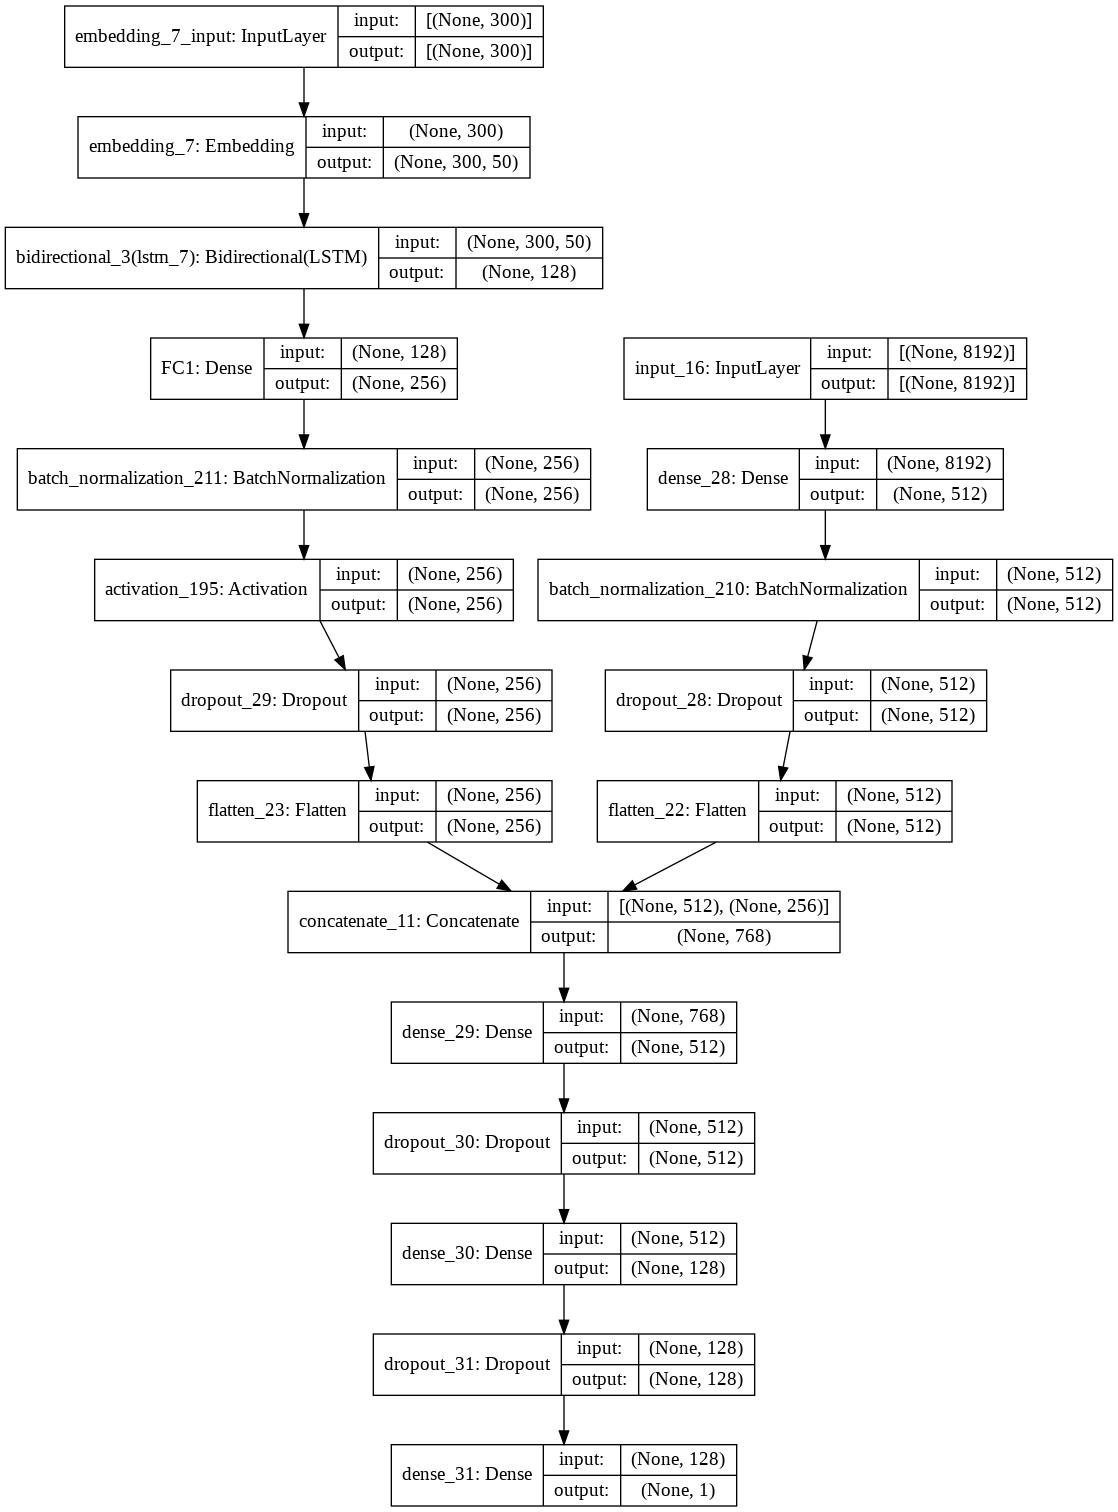

In [ ]:
plot_model(final_model, to_file='earlyfusionmodel.png', show_shapes=True, show_layer_names=True)

In [ ]:
history1 = final_model.fit([train_feat_vgg, X_train_title], Y_train,batch_size=64,epochs=15,verbose=1,validation_data=([val_feat_vgg, X_val_title],Y_val))

Epoch 1/15
10/10 [==============================] - 10s 605ms/step - loss: 0.6352 - accuracy: 0.7049 - val_loss: 0.7838 - val_accuracy: 0.8057
Epoch 2/15
10/10 [==============================] - 6s 576ms/step - loss: 0.4616 - accuracy: 0.8180 - val_loss: 0.8165 - val_accuracy: 0.8057
Epoch 3/15
10/10 [==============================] - 5s 524ms/step - loss: 0.3582 - accuracy: 0.8615 - val_loss: 0.8463 - val_accuracy: 0.8057
Epoch 4/15
10/10 [==============================] - 5s 511ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.6775 - val_accuracy: 0.8009
Epoch 5/15
10/10 [==============================] - 5s 504ms/step - loss: 0.1692 - accuracy: 0.9325 - val_loss: 1.2795 - val_accuracy: 0.8057
Epoch 6/15
10/10 [==============================] - 5s 506ms/step - loss: 0.0924 - accuracy: 0.9679 - val_loss: 1.3160 - val_accuracy: 0.8057
Epoch 7/15
10/10 [==============================] - 5s 503ms/step - loss: 0.0659 - accuracy: 0.9685 - val_loss: 1.5362 - val_accuracy: 0.8104
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


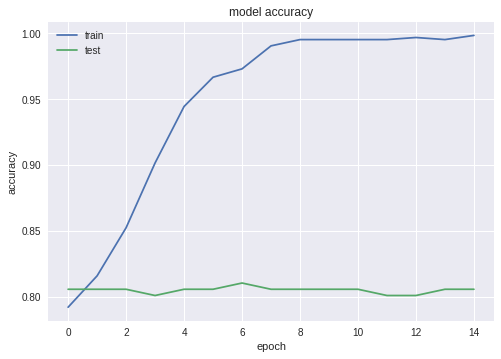

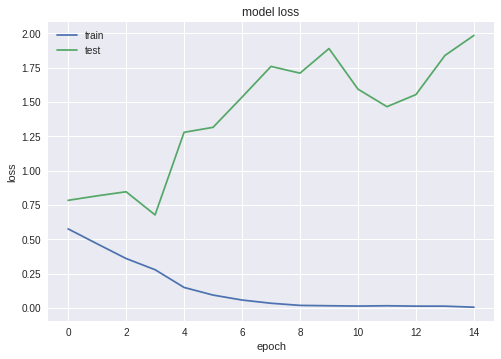

In [ ]:
print(history1.history.keys())
##################### summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
###################### summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Y_pred = final_model.predict([test_feat_vgg, X_test_title])
# Y_pred_prob_img = classifier_text.predict_proba(test_feat_vgg)

cm_img = confusion_matrix(Y_test, Y_pred.round())
print(cm_img)
print("\n")
accuracy_img = accuracy_score(Y_test, Y_pred.round())
print('Accuracy: %f' % accuracy_img)

[[  1  30]
 [  0 180]]


Accuracy: 0.857820


In [ ]:
###################        Save Image Model      ####################
final_model.save("final_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
final_model = load_model('final_model.h5')
# summarize model.
print(final_model.summary())

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_7_input (InputLayer)  [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 50)      50000       embedding_7_input[0][0]          
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128)          58880       embedding_7[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 8192)]       0                                            
___________________________________________________________________________________________

In [ ]:
#################################################   Blue Cnf matrix  #####################################################
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm1,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  accuracy = np.trace(cm1) / float(np.sum(cm1))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(6, 4))
  plt.imshow(cm1, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

  thresh = cm1.max() / 1.5 if normalize else cm1.max() / 2
  for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.4f}".format(cm1[i, j]),
            horizontalalignment="center",
            color="white" if cm1[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm1[i, j]),
            horizontalalignment="center",
            color="white" if cm1[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

[[  1  30]
 [  0 180]]


Accuracy: 0.857820


              precision    recall  f1-score   support

           0       1.00      0.03      0.06        31
           1       0.86      1.00      0.92       180

    accuracy                           0.86       211
   macro avg       0.93      0.52      0.49       211
weighted avg       0.88      0.86      0.80       211

roc_auc_score = 0.5601254480286738


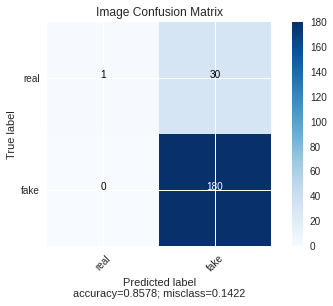

In [ ]:
###################################################   Results of VGG16 over Images    ########################################
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Y_pred = final_model.predict([test_feat_vgg, X_test_title])
#Y_pred_prob = final_model.predict_proba([test_feat_vgg, X_test_title])
cm_img = confusion_matrix(Y_test, Y_pred.round())
print(cm_img)
print("\n")
accuracy_img = accuracy_score(Y_test, Y_pred.round())
print('Accuracy: %f' % accuracy_img)
print("\n")

classreport_img = classification_report(Y_test, Y_pred.round())
print(classreport_img)
print("roc_auc_score =",roc_auc_score(Y_test, Y_pred, average='macro'))

plot_confusion_matrix(cm1 =cm_img, normalize = False,target_names = ['real','fake'],title = "Image Confusion Matrix")

No Skill: ROC AUC=0.500
VGG16: ROC AUC=0.560


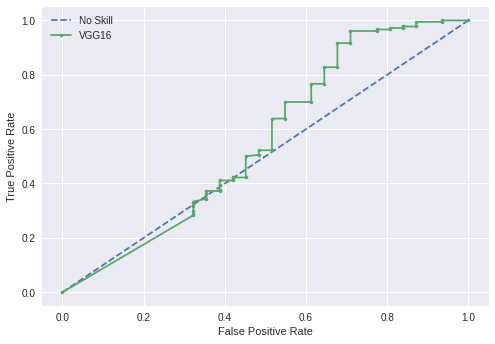

In [ ]:
###################################################   ROC for Images    ########################################
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y_test))]

# predict probabilities
lr_probs = Y_pred
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VGG16: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='VGG16')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()